# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "TEST_NULL" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "" # <== Pointing a file overrides the value set above.
IB_HYPERPARAMS_FILE = "" # <== Pointing a file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_CATB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/IB_CATB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (4574, 101)
IB Train Size: (4574, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrGetDllHandle,GetSystemInfo,NtDelayExecution,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NtClose,NtAllocateVirtualMemory,RegOpenKeyExW,RegCloseKey,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegCloseKey,RegQueryValueExW,RegCloseKey
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos,NtAllocateVirtualMemory,NtFreeVirtualMemory,GetCursorPos
2,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,GetSystemMetrics,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryW,LdrLoadDll,CreateThread,FindResourceExW,NtClose,GetSystemMetrics


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrGetDllHandle,GetSystemInfo,NtDelayExecution,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetProcedureAddress,CreateToolhelp32Snapshot,Thread32First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetSystemDirectoryW,NtDelayExecution,LdrLoadDll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,SHGetFolderPathW,SetErrorMode,GetFileAttributesW,CreateDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS):
    global TUNED_TRAINING
    indexes = get_indexes()
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=['Logloss', 'AUC', 'Precision'])
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=['Logloss', 'AUC', 'Precision'])

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS)
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()))
end_time("TB_CATB")

#Saving Model as file
tb_catb.save_model("Outputs/"+MODEL_FILENAME+"_TB_CATB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042239
0:	learn: 0.5783261	test: 0.5769325	best: 0.5769325 (0)	total: 239ms	remaining: 3m 58s
1:	learn: 0.4958724	test: 0.4932123	best: 0.4932123 (1)	total: 351ms	remaining: 2m 55s
2:	learn: 0.4150696	test: 0.4113361	best: 0.4113361 (2)	total: 456ms	remaining: 2m 31s
3:	learn: 0.3497078	test: 0.3454482	best: 0.3454482 (3)	total: 574ms	remaining: 2m 22s
4:	learn: 0.2984423	test: 0.2939199	best: 0.2939199 (4)	total: 687ms	remaining: 2m 16s
5:	learn: 0.2554364	test: 0.2510530	best: 0.2510530 (5)	total: 797ms	remaining: 2m 12s
6:	learn: 0.2224776	test: 0.2180540	best: 0.2180540 (6)	total: 909ms	remaining: 2m 8s
7:	learn: 0.1945561	test: 0.1904280	best: 0.1904280 (7)	total: 988ms	remaining: 2m 2s
8:	learn: 0.1722618	test: 0.1684837	best: 0.1684837 (8)	total: 1.07s	remaining: 1m 57s
9:	learn: 0.1531462	test: 0.1496973	best: 0.1496973 (9)	total: 1.18s	remaining: 1m 56s
10:	learn: 0.1380064	test: 0.1346227	best: 0.1346227 (10)	total: 1.25s	remaining: 1m 52s
11:	learn: 0.

93:	learn: 0.0129739	test: 0.2013679	best: 0.1009425 (23)	total: 13.8s	remaining: 2m 13s
94:	learn: 0.0128564	test: 0.2003556	best: 0.1009425 (23)	total: 14s	remaining: 2m 13s
95:	learn: 0.0126965	test: 0.1975150	best: 0.1009425 (23)	total: 14.2s	remaining: 2m 13s
96:	learn: 0.0125867	test: 0.1976499	best: 0.1009425 (23)	total: 14.3s	remaining: 2m 13s
97:	learn: 0.0124675	test: 0.1945319	best: 0.1009425 (23)	total: 14.5s	remaining: 2m 13s
98:	learn: 0.0123964	test: 0.1933877	best: 0.1009425 (23)	total: 14.6s	remaining: 2m 13s
99:	learn: 0.0121397	test: 0.1955275	best: 0.1009425 (23)	total: 14.8s	remaining: 2m 12s
100:	learn: 0.0120969	test: 0.1981592	best: 0.1009425 (23)	total: 14.9s	remaining: 2m 12s
101:	learn: 0.0119422	test: 0.2010824	best: 0.1009425 (23)	total: 15.1s	remaining: 2m 12s
102:	learn: 0.0117823	test: 0.2044594	best: 0.1009425 (23)	total: 15.3s	remaining: 2m 13s
103:	learn: 0.0116033	test: 0.2091563	best: 0.1009425 (23)	total: 15.4s	remaining: 2m 12s
104:	learn: 0.01150

187:	learn: 0.0055626	test: 0.2799902	best: 0.1009425 (23)	total: 28.1s	remaining: 2m 1s
188:	learn: 0.0055154	test: 0.2818277	best: 0.1009425 (23)	total: 28.2s	remaining: 2m 1s
189:	learn: 0.0054610	test: 0.2886783	best: 0.1009425 (23)	total: 28.4s	remaining: 2m
190:	learn: 0.0054180	test: 0.2886073	best: 0.1009425 (23)	total: 28.5s	remaining: 2m
191:	learn: 0.0053803	test: 0.2948264	best: 0.1009425 (23)	total: 28.6s	remaining: 2m
192:	learn: 0.0053194	test: 0.2953550	best: 0.1009425 (23)	total: 28.8s	remaining: 2m
193:	learn: 0.0052594	test: 0.2947457	best: 0.1009425 (23)	total: 28.9s	remaining: 2m
194:	learn: 0.0052161	test: 0.2957361	best: 0.1009425 (23)	total: 29.1s	remaining: 2m
195:	learn: 0.0051756	test: 0.3011057	best: 0.1009425 (23)	total: 29.2s	remaining: 1m 59s
196:	learn: 0.0051062	test: 0.2966010	best: 0.1009425 (23)	total: 29.4s	remaining: 1m 59s
197:	learn: 0.0050635	test: 0.3012690	best: 0.1009425 (23)	total: 29.5s	remaining: 1m 59s
198:	learn: 0.0050225	test: 0.303604

279:	learn: 0.0030339	test: 0.4420979	best: 0.1009425 (23)	total: 42.6s	remaining: 1m 49s
280:	learn: 0.0030184	test: 0.4441933	best: 0.1009425 (23)	total: 42.8s	remaining: 1m 49s
281:	learn: 0.0030034	test: 0.4485534	best: 0.1009425 (23)	total: 43s	remaining: 1m 49s
282:	learn: 0.0029875	test: 0.4549268	best: 0.1009425 (23)	total: 43.1s	remaining: 1m 49s
283:	learn: 0.0029742	test: 0.4545462	best: 0.1009425 (23)	total: 43.3s	remaining: 1m 49s
284:	learn: 0.0029559	test: 0.4508291	best: 0.1009425 (23)	total: 43.5s	remaining: 1m 49s
285:	learn: 0.0029436	test: 0.4525807	best: 0.1009425 (23)	total: 43.6s	remaining: 1m 48s
286:	learn: 0.0029300	test: 0.4494910	best: 0.1009425 (23)	total: 43.8s	remaining: 1m 48s
287:	learn: 0.0029101	test: 0.4503916	best: 0.1009425 (23)	total: 44s	remaining: 1m 48s
288:	learn: 0.0028904	test: 0.4503692	best: 0.1009425 (23)	total: 44.1s	remaining: 1m 48s
289:	learn: 0.0028731	test: 0.4477816	best: 0.1009425 (23)	total: 44.3s	remaining: 1m 48s
290:	learn: 0.

372:	learn: 0.0022857	test: 0.4686004	best: 0.1009425 (23)	total: 57.8s	remaining: 1m 37s
373:	learn: 0.0022855	test: 0.4685267	best: 0.1009425 (23)	total: 58s	remaining: 1m 37s
374:	learn: 0.0022855	test: 0.4685143	best: 0.1009425 (23)	total: 58.1s	remaining: 1m 36s
375:	learn: 0.0022854	test: 0.4685095	best: 0.1009425 (23)	total: 58.3s	remaining: 1m 36s
376:	learn: 0.0022854	test: 0.4685095	best: 0.1009425 (23)	total: 58.4s	remaining: 1m 36s
377:	learn: 0.0022854	test: 0.4685145	best: 0.1009425 (23)	total: 58.5s	remaining: 1m 36s
378:	learn: 0.0022854	test: 0.4685021	best: 0.1009425 (23)	total: 58.6s	remaining: 1m 36s
379:	learn: 0.0022734	test: 0.4618160	best: 0.1009425 (23)	total: 58.8s	remaining: 1m 35s
380:	learn: 0.0022734	test: 0.4618098	best: 0.1009425 (23)	total: 58.9s	remaining: 1m 35s
381:	learn: 0.0022603	test: 0.4526036	best: 0.1009425 (23)	total: 59.1s	remaining: 1m 35s
382:	learn: 0.0022603	test: 0.4526015	best: 0.1009425 (23)	total: 59.2s	remaining: 1m 35s
383:	learn: 

464:	learn: 0.0021820	test: 0.4471513	best: 0.1009425 (23)	total: 1m 11s	remaining: 1m 22s
465:	learn: 0.0021820	test: 0.4471634	best: 0.1009425 (23)	total: 1m 11s	remaining: 1m 22s
466:	learn: 0.0021820	test: 0.4471635	best: 0.1009425 (23)	total: 1m 11s	remaining: 1m 21s
467:	learn: 0.0021820	test: 0.4471596	best: 0.1009425 (23)	total: 1m 11s	remaining: 1m 21s
468:	learn: 0.0021820	test: 0.4471596	best: 0.1009425 (23)	total: 1m 12s	remaining: 1m 21s
469:	learn: 0.0021820	test: 0.4471591	best: 0.1009425 (23)	total: 1m 12s	remaining: 1m 21s
470:	learn: 0.0021820	test: 0.4471651	best: 0.1009425 (23)	total: 1m 12s	remaining: 1m 21s
471:	learn: 0.0021819	test: 0.4471612	best: 0.1009425 (23)	total: 1m 12s	remaining: 1m 21s
472:	learn: 0.0021819	test: 0.4471573	best: 0.1009425 (23)	total: 1m 12s	remaining: 1m 21s
473:	learn: 0.0021819	test: 0.4471573	best: 0.1009425 (23)	total: 1m 12s	remaining: 1m 21s
474:	learn: 0.0021819	test: 0.4471679	best: 0.1009425 (23)	total: 1m 13s	remaining: 1m 20s

556:	learn: 0.0021513	test: 0.4487085	best: 0.1009425 (23)	total: 1m 26s	remaining: 1m 8s
557:	learn: 0.0021513	test: 0.4487000	best: 0.1009425 (23)	total: 1m 26s	remaining: 1m 8s
558:	learn: 0.0021513	test: 0.4487023	best: 0.1009425 (23)	total: 1m 26s	remaining: 1m 8s
559:	learn: 0.0021512	test: 0.4486937	best: 0.1009425 (23)	total: 1m 26s	remaining: 1m 8s
560:	learn: 0.0021512	test: 0.4486899	best: 0.1009425 (23)	total: 1m 27s	remaining: 1m 8s
561:	learn: 0.0021512	test: 0.4486899	best: 0.1009425 (23)	total: 1m 27s	remaining: 1m 8s
562:	learn: 0.0021512	test: 0.4486814	best: 0.1009425 (23)	total: 1m 27s	remaining: 1m 7s
563:	learn: 0.0021512	test: 0.4486809	best: 0.1009425 (23)	total: 1m 27s	remaining: 1m 7s
564:	learn: 0.0021512	test: 0.4486771	best: 0.1009425 (23)	total: 1m 27s	remaining: 1m 7s
565:	learn: 0.0021512	test: 0.4486766	best: 0.1009425 (23)	total: 1m 27s	remaining: 1m 7s
566:	learn: 0.0021512	test: 0.4486766	best: 0.1009425 (23)	total: 1m 28s	remaining: 1m 7s
567:	learn

649:	learn: 0.0021501	test: 0.4485914	best: 0.1009425 (23)	total: 1m 41s	remaining: 54.8s
650:	learn: 0.0021501	test: 0.4485904	best: 0.1009425 (23)	total: 1m 42s	remaining: 54.7s
651:	learn: 0.0021500	test: 0.4485899	best: 0.1009425 (23)	total: 1m 42s	remaining: 54.6s
652:	learn: 0.0021500	test: 0.4485894	best: 0.1009425 (23)	total: 1m 42s	remaining: 54.4s
653:	learn: 0.0021500	test: 0.4485874	best: 0.1009425 (23)	total: 1m 42s	remaining: 54.3s
654:	learn: 0.0021500	test: 0.4485865	best: 0.1009425 (23)	total: 1m 42s	remaining: 54.1s
655:	learn: 0.0021500	test: 0.4485966	best: 0.1009425 (23)	total: 1m 42s	remaining: 53.9s
656:	learn: 0.0021500	test: 0.4485957	best: 0.1009425 (23)	total: 1m 43s	remaining: 53.8s
657:	learn: 0.0021500	test: 0.4485947	best: 0.1009425 (23)	total: 1m 43s	remaining: 53.6s
658:	learn: 0.0021500	test: 0.4485942	best: 0.1009425 (23)	total: 1m 43s	remaining: 53.5s
659:	learn: 0.0021500	test: 0.4485937	best: 0.1009425 (23)	total: 1m 43s	remaining: 53.3s
660:	learn

742:	learn: 0.0021491	test: 0.4484953	best: 0.1009425 (23)	total: 1m 57s	remaining: 40.6s
743:	learn: 0.0021491	test: 0.4484953	best: 0.1009425 (23)	total: 1m 57s	remaining: 40.4s
744:	learn: 0.0021491	test: 0.4484915	best: 0.1009425 (23)	total: 1m 57s	remaining: 40.3s
745:	learn: 0.0021491	test: 0.4484896	best: 0.1009425 (23)	total: 1m 57s	remaining: 40.1s
746:	learn: 0.0021491	test: 0.4484875	best: 0.1009425 (23)	total: 1m 57s	remaining: 39.9s
747:	learn: 0.0021491	test: 0.4484799	best: 0.1009425 (23)	total: 1m 58s	remaining: 39.8s
748:	learn: 0.0021491	test: 0.4484794	best: 0.1009425 (23)	total: 1m 58s	remaining: 39.6s
749:	learn: 0.0021490	test: 0.4484775	best: 0.1009425 (23)	total: 1m 58s	remaining: 39.5s
750:	learn: 0.0021490	test: 0.4484754	best: 0.1009425 (23)	total: 1m 58s	remaining: 39.3s
751:	learn: 0.0021490	test: 0.4484732	best: 0.1009425 (23)	total: 1m 58s	remaining: 39.2s
752:	learn: 0.0021490	test: 0.4484733	best: 0.1009425 (23)	total: 1m 58s	remaining: 39s
753:	learn: 

834:	learn: 0.0021299	test: 0.4475605	best: 0.1009425 (23)	total: 2m 16s	remaining: 27.1s
835:	learn: 0.0021131	test: 0.4468597	best: 0.1009425 (23)	total: 2m 17s	remaining: 26.9s
836:	learn: 0.0021131	test: 0.4468606	best: 0.1009425 (23)	total: 2m 17s	remaining: 26.7s
837:	learn: 0.0021130	test: 0.4468531	best: 0.1009425 (23)	total: 2m 17s	remaining: 26.6s
838:	learn: 0.0021130	test: 0.4468521	best: 0.1009425 (23)	total: 2m 17s	remaining: 26.4s
839:	learn: 0.0021130	test: 0.4468512	best: 0.1009425 (23)	total: 2m 17s	remaining: 26.3s
840:	learn: 0.0021047	test: 0.4467504	best: 0.1009425 (23)	total: 2m 18s	remaining: 26.1s
841:	learn: 0.0020884	test: 0.4446503	best: 0.1009425 (23)	total: 2m 18s	remaining: 26s
842:	learn: 0.0020805	test: 0.4447836	best: 0.1009425 (23)	total: 2m 18s	remaining: 25.8s
843:	learn: 0.0020805	test: 0.4447831	best: 0.1009425 (23)	total: 2m 18s	remaining: 25.7s
844:	learn: 0.0020805	test: 0.4447827	best: 0.1009425 (23)	total: 2m 18s	remaining: 25.5s
845:	learn: 

926:	learn: 0.0019324	test: 0.4441766	best: 0.1009425 (23)	total: 2m 33s	remaining: 12.1s
927:	learn: 0.0019324	test: 0.4441772	best: 0.1009425 (23)	total: 2m 33s	remaining: 11.9s
928:	learn: 0.0019324	test: 0.4441777	best: 0.1009425 (23)	total: 2m 34s	remaining: 11.8s
929:	learn: 0.0019324	test: 0.4441768	best: 0.1009425 (23)	total: 2m 34s	remaining: 11.6s
930:	learn: 0.0019324	test: 0.4441752	best: 0.1009425 (23)	total: 2m 34s	remaining: 11.5s
931:	learn: 0.0019323	test: 0.4441737	best: 0.1009425 (23)	total: 2m 34s	remaining: 11.3s
932:	learn: 0.0019323	test: 0.4441721	best: 0.1009425 (23)	total: 2m 34s	remaining: 11.1s
933:	learn: 0.0019323	test: 0.4441644	best: 0.1009425 (23)	total: 2m 35s	remaining: 11s
934:	learn: 0.0019265	test: 0.4468014	best: 0.1009425 (23)	total: 2m 35s	remaining: 10.8s
935:	learn: 0.0019265	test: 0.4468111	best: 0.1009425 (23)	total: 2m 35s	remaining: 10.6s
936:	learn: 0.0019265	test: 0.4468110	best: 0.1009425 (23)	total: 2m 35s	remaining: 10.5s
937:	learn: 

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [11]:
print(classification_report(y_tb_validate, tb_catb.predict(X_tb_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9915    0.9791    0.9852       716
           1     0.9775    0.9909    0.9841       657

    accuracy                         0.9847      1373
   macro avg     0.9845    0.9850    0.9847      1373
weighted avg     0.9848    0.9847    0.9847      1373



### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

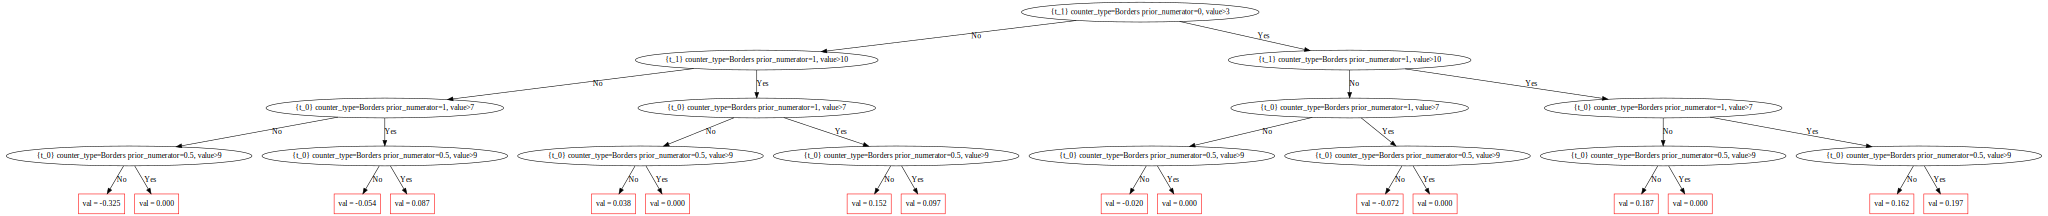

In [12]:
tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS)
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()))
end_time("TB_CATB")
end_time("IB_CATB")

#Saving Model as file
ib_catb.save_model("Outputs/"+MODEL_FILENAME+"_IB_CATB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042239
0:	learn: 0.6318447	test: 0.6321847	best: 0.6321847 (0)	total: 39.3ms	remaining: 39.2s
1:	learn: 0.5400459	test: 0.5376970	best: 0.5376970 (1)	total: 128ms	remaining: 1m 3s
2:	learn: 0.4965312	test: 0.4945234	best: 0.4945234 (2)	total: 161ms	remaining: 53.4s
3:	learn: 0.4348965	test: 0.4327457	best: 0.4327457 (3)	total: 288ms	remaining: 1m 11s
4:	learn: 0.3835468	test: 0.3812712	best: 0.3812712 (4)	total: 335ms	remaining: 1m 6s
5:	learn: 0.3394733	test: 0.3369557	best: 0.3369557 (5)	total: 405ms	remaining: 1m 7s
6:	learn: 0.3015300	test: 0.2990331	best: 0.2990331 (6)	total: 470ms	remaining: 1m 6s
7:	learn: 0.2633777	test: 0.2607343	best: 0.2607343 (7)	total: 524ms	remaining: 1m 4s
8:	learn: 0.2272307	test: 0.2244057	best: 0.2244057 (8)	total: 596ms	remaining: 1m 5s
9:	learn: 0.2054129	test: 0.2024966	best: 0.2024966 (9)	total: 697ms	remaining: 1m 8s
10:	learn: 0.1870652	test: 0.1843067	best: 0.1843067 (10)	total: 824ms	remaining: 1m 14s
11:	learn: 0.172315

93:	learn: 0.0186986	test: 0.0344510	best: 0.0344510 (93)	total: 10.5s	remaining: 1m 41s
94:	learn: 0.0184823	test: 0.0344128	best: 0.0344128 (94)	total: 10.6s	remaining: 1m 41s
95:	learn: 0.0183547	test: 0.0343091	best: 0.0343091 (95)	total: 10.8s	remaining: 1m 41s
96:	learn: 0.0182943	test: 0.0343042	best: 0.0343042 (96)	total: 10.9s	remaining: 1m 41s
97:	learn: 0.0181165	test: 0.0343727	best: 0.0343042 (96)	total: 11s	remaining: 1m 40s
98:	learn: 0.0180968	test: 0.0343628	best: 0.0343042 (96)	total: 11.1s	remaining: 1m 40s
99:	learn: 0.0178897	test: 0.0342701	best: 0.0342701 (99)	total: 11.2s	remaining: 1m 40s
100:	learn: 0.0178897	test: 0.0342701	best: 0.0342701 (100)	total: 11.2s	remaining: 1m 39s
101:	learn: 0.0176818	test: 0.0342021	best: 0.0342021 (101)	total: 11.3s	remaining: 1m 39s
102:	learn: 0.0174037	test: 0.0340746	best: 0.0340746 (102)	total: 11.4s	remaining: 1m 39s
103:	learn: 0.0172629	test: 0.0340593	best: 0.0340593 (103)	total: 11.5s	remaining: 1m 39s
104:	learn: 0.0

184:	learn: 0.0099244	test: 0.0332916	best: 0.0329392 (160)	total: 20.5s	remaining: 1m 30s
185:	learn: 0.0099243	test: 0.0332914	best: 0.0329392 (160)	total: 20.6s	remaining: 1m 30s
186:	learn: 0.0098397	test: 0.0332471	best: 0.0329392 (160)	total: 20.7s	remaining: 1m 30s
187:	learn: 0.0098182	test: 0.0332178	best: 0.0329392 (160)	total: 20.8s	remaining: 1m 29s
188:	learn: 0.0097627	test: 0.0332089	best: 0.0329392 (160)	total: 20.9s	remaining: 1m 29s
189:	learn: 0.0097128	test: 0.0332422	best: 0.0329392 (160)	total: 21s	remaining: 1m 29s
190:	learn: 0.0096191	test: 0.0332270	best: 0.0329392 (160)	total: 21.1s	remaining: 1m 29s
191:	learn: 0.0095648	test: 0.0332248	best: 0.0329392 (160)	total: 21.2s	remaining: 1m 29s
192:	learn: 0.0095076	test: 0.0332013	best: 0.0329392 (160)	total: 21.3s	remaining: 1m 29s
193:	learn: 0.0094069	test: 0.0331799	best: 0.0329392 (160)	total: 21.4s	remaining: 1m 29s
194:	learn: 0.0093991	test: 0.0331735	best: 0.0329392 (160)	total: 21.5s	remaining: 1m 28s
1

277:	learn: 0.0057656	test: 0.0335238	best: 0.0327037 (231)	total: 29.2s	remaining: 1m 15s
278:	learn: 0.0057340	test: 0.0335315	best: 0.0327037 (231)	total: 29.3s	remaining: 1m 15s
279:	learn: 0.0056476	test: 0.0335932	best: 0.0327037 (231)	total: 29.4s	remaining: 1m 15s
280:	learn: 0.0055768	test: 0.0337123	best: 0.0327037 (231)	total: 29.5s	remaining: 1m 15s
281:	learn: 0.0055635	test: 0.0337467	best: 0.0327037 (231)	total: 29.6s	remaining: 1m 15s
282:	learn: 0.0055110	test: 0.0338271	best: 0.0327037 (231)	total: 29.7s	remaining: 1m 15s
283:	learn: 0.0055110	test: 0.0338270	best: 0.0327037 (231)	total: 29.7s	remaining: 1m 14s
284:	learn: 0.0055109	test: 0.0338269	best: 0.0327037 (231)	total: 29.8s	remaining: 1m 14s
285:	learn: 0.0054968	test: 0.0338196	best: 0.0327037 (231)	total: 29.9s	remaining: 1m 14s
286:	learn: 0.0054281	test: 0.0339357	best: 0.0327037 (231)	total: 30s	remaining: 1m 14s
287:	learn: 0.0054134	test: 0.0339593	best: 0.0327037 (231)	total: 30.1s	remaining: 1m 14s
2

368:	learn: 0.0041203	test: 0.0351321	best: 0.0327037 (231)	total: 37.3s	remaining: 1m 3s
369:	learn: 0.0041152	test: 0.0351405	best: 0.0327037 (231)	total: 37.4s	remaining: 1m 3s
370:	learn: 0.0041075	test: 0.0351362	best: 0.0327037 (231)	total: 37.5s	remaining: 1m 3s
371:	learn: 0.0041074	test: 0.0351361	best: 0.0327037 (231)	total: 37.6s	remaining: 1m 3s
372:	learn: 0.0040944	test: 0.0351115	best: 0.0327037 (231)	total: 37.7s	remaining: 1m 3s
373:	learn: 0.0040897	test: 0.0351195	best: 0.0327037 (231)	total: 37.8s	remaining: 1m 3s
374:	learn: 0.0040745	test: 0.0350940	best: 0.0327037 (231)	total: 37.9s	remaining: 1m 3s
375:	learn: 0.0040641	test: 0.0350844	best: 0.0327037 (231)	total: 38s	remaining: 1m 2s
376:	learn: 0.0040156	test: 0.0351047	best: 0.0327037 (231)	total: 38s	remaining: 1m 2s
377:	learn: 0.0039702	test: 0.0351253	best: 0.0327037 (231)	total: 38.1s	remaining: 1m 2s
378:	learn: 0.0039484	test: 0.0351483	best: 0.0327037 (231)	total: 38.2s	remaining: 1m 2s
379:	learn: 0.

460:	learn: 0.0032454	test: 0.0356608	best: 0.0327037 (231)	total: 46.9s	remaining: 54.9s
461:	learn: 0.0032260	test: 0.0357469	best: 0.0327037 (231)	total: 47s	remaining: 54.8s
462:	learn: 0.0032202	test: 0.0357370	best: 0.0327037 (231)	total: 47.1s	remaining: 54.7s
463:	learn: 0.0032051	test: 0.0357546	best: 0.0327037 (231)	total: 47.2s	remaining: 54.5s
464:	learn: 0.0032050	test: 0.0357546	best: 0.0327037 (231)	total: 47.3s	remaining: 54.4s
465:	learn: 0.0032050	test: 0.0357548	best: 0.0327037 (231)	total: 47.4s	remaining: 54.4s
466:	learn: 0.0031869	test: 0.0358390	best: 0.0327037 (231)	total: 47.5s	remaining: 54.2s
467:	learn: 0.0031702	test: 0.0358360	best: 0.0327037 (231)	total: 47.6s	remaining: 54.1s
468:	learn: 0.0031622	test: 0.0358346	best: 0.0327037 (231)	total: 47.7s	remaining: 54s
469:	learn: 0.0031622	test: 0.0358346	best: 0.0327037 (231)	total: 47.8s	remaining: 53.9s
470:	learn: 0.0031622	test: 0.0358347	best: 0.0327037 (231)	total: 47.9s	remaining: 53.8s
471:	learn: 0.

553:	learn: 0.0028808	test: 0.0360643	best: 0.0327037 (231)	total: 56.2s	remaining: 45.2s
554:	learn: 0.0028808	test: 0.0360643	best: 0.0327037 (231)	total: 56.3s	remaining: 45.1s
555:	learn: 0.0028808	test: 0.0360643	best: 0.0327037 (231)	total: 56.4s	remaining: 45s
556:	learn: 0.0028808	test: 0.0360643	best: 0.0327037 (231)	total: 56.4s	remaining: 44.9s
557:	learn: 0.0028807	test: 0.0360643	best: 0.0327037 (231)	total: 56.5s	remaining: 44.8s
558:	learn: 0.0028807	test: 0.0360643	best: 0.0327037 (231)	total: 56.6s	remaining: 44.7s
559:	learn: 0.0028807	test: 0.0360643	best: 0.0327037 (231)	total: 56.7s	remaining: 44.6s
560:	learn: 0.0028807	test: 0.0360644	best: 0.0327037 (231)	total: 56.8s	remaining: 44.4s
561:	learn: 0.0028807	test: 0.0360645	best: 0.0327037 (231)	total: 56.9s	remaining: 44.3s
562:	learn: 0.0028807	test: 0.0360646	best: 0.0327037 (231)	total: 57s	remaining: 44.2s
563:	learn: 0.0028807	test: 0.0360647	best: 0.0327037 (231)	total: 57.1s	remaining: 44.1s
564:	learn: 0.

646:	learn: 0.0027955	test: 0.0360822	best: 0.0327037 (231)	total: 1m 5s	remaining: 35.6s
647:	learn: 0.0027955	test: 0.0360822	best: 0.0327037 (231)	total: 1m 5s	remaining: 35.5s
648:	learn: 0.0027895	test: 0.0360858	best: 0.0327037 (231)	total: 1m 5s	remaining: 35.4s
649:	learn: 0.0027894	test: 0.0360859	best: 0.0327037 (231)	total: 1m 5s	remaining: 35.3s
650:	learn: 0.0027894	test: 0.0360861	best: 0.0327037 (231)	total: 1m 5s	remaining: 35.2s
651:	learn: 0.0027812	test: 0.0360836	best: 0.0327037 (231)	total: 1m 5s	remaining: 35.1s
652:	learn: 0.0027812	test: 0.0360836	best: 0.0327037 (231)	total: 1m 5s	remaining: 35s
653:	learn: 0.0027812	test: 0.0360837	best: 0.0327037 (231)	total: 1m 6s	remaining: 34.9s
654:	learn: 0.0027812	test: 0.0360837	best: 0.0327037 (231)	total: 1m 6s	remaining: 34.9s
655:	learn: 0.0027619	test: 0.0360643	best: 0.0327037 (231)	total: 1m 6s	remaining: 34.8s
656:	learn: 0.0027493	test: 0.0360873	best: 0.0327037 (231)	total: 1m 6s	remaining: 34.7s
657:	learn: 

738:	learn: 0.0024680	test: 0.0364152	best: 0.0327037 (231)	total: 1m 15s	remaining: 26.7s
739:	learn: 0.0024530	test: 0.0364440	best: 0.0327037 (231)	total: 1m 15s	remaining: 26.6s
740:	learn: 0.0024450	test: 0.0365121	best: 0.0327037 (231)	total: 1m 15s	remaining: 26.5s
741:	learn: 0.0024450	test: 0.0365122	best: 0.0327037 (231)	total: 1m 15s	remaining: 26.4s
742:	learn: 0.0024318	test: 0.0365558	best: 0.0327037 (231)	total: 1m 15s	remaining: 26.3s
743:	learn: 0.0024244	test: 0.0365782	best: 0.0327037 (231)	total: 1m 16s	remaining: 26.2s
744:	learn: 0.0024244	test: 0.0365782	best: 0.0327037 (231)	total: 1m 16s	remaining: 26.1s
745:	learn: 0.0024244	test: 0.0365782	best: 0.0327037 (231)	total: 1m 16s	remaining: 26s
746:	learn: 0.0024113	test: 0.0366024	best: 0.0327037 (231)	total: 1m 16s	remaining: 25.9s
747:	learn: 0.0024113	test: 0.0366024	best: 0.0327037 (231)	total: 1m 16s	remaining: 25.8s
748:	learn: 0.0024112	test: 0.0366024	best: 0.0327037 (231)	total: 1m 16s	remaining: 25.7s
7

830:	learn: 0.0022379	test: 0.0369159	best: 0.0327037 (231)	total: 1m 25s	remaining: 17.4s
831:	learn: 0.0022379	test: 0.0369159	best: 0.0327037 (231)	total: 1m 25s	remaining: 17.3s
832:	learn: 0.0022379	test: 0.0369159	best: 0.0327037 (231)	total: 1m 25s	remaining: 17.2s
833:	learn: 0.0022378	test: 0.0369160	best: 0.0327037 (231)	total: 1m 26s	remaining: 17.1s
834:	learn: 0.0022378	test: 0.0369160	best: 0.0327037 (231)	total: 1m 26s	remaining: 17s
835:	learn: 0.0022378	test: 0.0369160	best: 0.0327037 (231)	total: 1m 26s	remaining: 16.9s
836:	learn: 0.0022378	test: 0.0369160	best: 0.0327037 (231)	total: 1m 26s	remaining: 16.8s
837:	learn: 0.0022378	test: 0.0369160	best: 0.0327037 (231)	total: 1m 26s	remaining: 16.7s
838:	learn: 0.0022378	test: 0.0369161	best: 0.0327037 (231)	total: 1m 26s	remaining: 16.6s
839:	learn: 0.0022378	test: 0.0369161	best: 0.0327037 (231)	total: 1m 26s	remaining: 16.5s
840:	learn: 0.0022378	test: 0.0369161	best: 0.0327037 (231)	total: 1m 26s	remaining: 16.4s
8

921:	learn: 0.0022335	test: 0.0369270	best: 0.0327037 (231)	total: 1m 35s	remaining: 8.07s
922:	learn: 0.0022335	test: 0.0369270	best: 0.0327037 (231)	total: 1m 35s	remaining: 7.96s
923:	learn: 0.0022335	test: 0.0369271	best: 0.0327037 (231)	total: 1m 35s	remaining: 7.86s
924:	learn: 0.0022335	test: 0.0369272	best: 0.0327037 (231)	total: 1m 35s	remaining: 7.75s
925:	learn: 0.0022335	test: 0.0369272	best: 0.0327037 (231)	total: 1m 35s	remaining: 7.65s
926:	learn: 0.0022334	test: 0.0369272	best: 0.0327037 (231)	total: 1m 35s	remaining: 7.55s
927:	learn: 0.0022334	test: 0.0369273	best: 0.0327037 (231)	total: 1m 35s	remaining: 7.44s
928:	learn: 0.0022334	test: 0.0369273	best: 0.0327037 (231)	total: 1m 36s	remaining: 7.34s
929:	learn: 0.0022334	test: 0.0369273	best: 0.0327037 (231)	total: 1m 36s	remaining: 7.23s
930:	learn: 0.0022334	test: 0.0369273	best: 0.0327037 (231)	total: 1m 36s	remaining: 7.13s
931:	learn: 0.0022334	test: 0.0369273	best: 0.0327037 (231)	total: 1m 36s	remaining: 7.04s

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [14]:
print(classification_report(y_ib_validate, ib_catb.predict(X_ib_validate),digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9827    0.9913       694
           1     0.9826    1.0000    0.9912       679

    accuracy                         0.9913      1373
   macro avg     0.9913    0.9914    0.9913      1373
weighted avg     0.9914    0.9913    0.9913      1373



### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

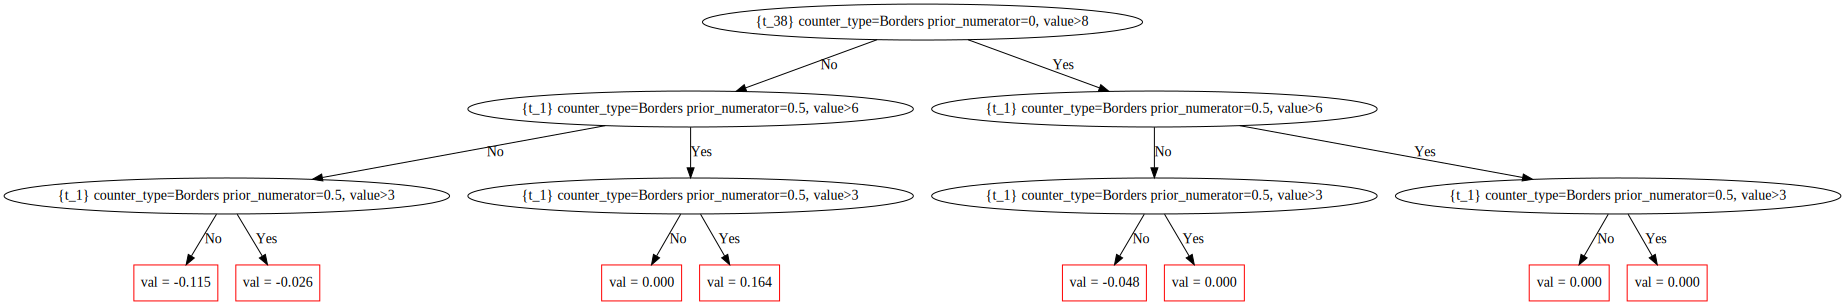

In [15]:
ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))

In [16]:
logging("\n")